In [1]:
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Implicit(nn.Module):
  def __init__(self, fun, dimension, radius=1):
    super(Implicit, self).__init__()

    d_in = dimension
    dims = [512, 512, 512, 512, 512, 512, 512, 512]
    beta = 100
    skip_in = [4]
    radius_init = radius

    dims = [d_in] + dims + [1]

    self.num_layers = len(dims)
    self.skip_in = skip_in

    for layer in range(0, self.num_layers - 1):

      if layer + 1 in skip_in:
        out_dim = dims[layer + 1] - d_in
      else:
        out_dim = dims[layer + 1]

      lin = nn.Linear(dims[layer], out_dim)

      if layer == self.num_layers - 2:
        torch.nn.init.normal_(lin.weight, mean=np.sqrt(np.pi) / np.sqrt(dims[layer]), std=0.00001)
        torch.nn.init.constant_(lin.bias, -radius_init)
      else:
        torch.nn.init.constant_(lin.bias, 0.0)
        torch.nn.init.normal_(lin.weight, 0.0, np.sqrt(2) / np.sqrt(out_dim))

      setattr(self, "lin" + str(layer), lin)

    self.activation = nn.Softplus(beta=beta)
    #self.activation = nn.ReLU()
    self.fun = fun


  def forward(self, input):
    x = input
    for layer in range(0, self.num_layers - 1):
      lin = getattr(self, "lin" + str(layer))
      if layer in self.skip_in:
        x = torch.cat([x, input], -1) / np.sqrt(2)
      x = lin(x)
      if layer < self.num_layers - 2:
        x = self.activation(x)
    fun_sign = torch.tanh(0.1*self.fun(input))
    fun_sign = fun_sign.reshape(x.shape)
    x = x * fun_sign
    return x

In [3]:
def grad(y, x, grad_outputs=None):
  if grad_outputs is None:
    grad_outputs = torch.ones_like(y)
  grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
  return grad

def div(y, x):
  div = 0.
  for i in range(y.shape[-1]):
    div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
  return div

def laplacian(y, x):
  grad = grad(y, x)
  return div(grad, x)

def pLaplacian(y, x, p=2):
  g = grad(y, x)
  #g_n = g.norm(2, dim=1)
  g_n = torch.linalg.norm(g, 2, dim=1)
  g_n = g_n**(p-2)
  g_n = torch.reshape(g_n, (g.shape[0],1))
  g = g_n * g
  return div(g, x)

In [4]:
def uniform_data(num_points, device, xbounds):
  xmin, xmax = xbounds
  x = torch.FloatTensor(num_points, 1).uniform_(xmin, xmax)
  return x.to(device)

def grid_data(num_points, device, xbounds):
  xmin, xmax = xbounds
  x = torch.linspace(xmin, xmax, num_points, requires_grad=True, device=device)
  xt = x.resize(x.shape[0],1)
  return xt

In [5]:
def trainPPoisson(num_iters, fun, xbounds, p=2, device='cpu'):
  model = Implicit(fun=fun, dimension=1).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  n_samples = 256
  loss = 0

  # Train network
  for i in range(0, num_iters):
    # Uniform samples
    u = uniform_data(n_samples, device, xbounds)
    u.requires_grad = True
    
    model.train()
    optimizer.zero_grad()
    
    f_d = model(u)
    
    # p-Laplacian
    lap = pLaplacian(f_d, u, p)
    lap_loss = torch.mean((lap+1)**2)
    loss = lap_loss

    loss.backward()

    #clip_grad = 1.0
    #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)

    optimizer.step()
  
  return model

In [6]:
def trainEikonal(num_iters, fun, xbounds, device='cpu'):
  model = Implicit(fun=fun, dimension=1).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  n_samples = 256
  loss = 0

  # Train network
  for i in range(0, num_iters):
    # Uniform samples
    u = uniform_data(n_samples, device, xbounds)
    u.requires_grad = True
    
    model.train()
    optimizer.zero_grad()

    f_d = model(u)
    
    g_d = grad(f_d, u)
    g_norm = (g_d.norm(2, dim=1) - 1)**2
    eik_loss = torch.mean(g_norm)
    loss = eik_loss

    loss.backward()

    #clip_grad = 1.0
    #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)

    optimizer.step()
  
  return model

In [7]:
def f(x):
  x1 = x
  x2 = 1-x
  return x1+x2-torch.sqrt(x1**2+x2**2)

In [8]:
# Domain boundary
xbounds = (-2.0, 3.0)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
x = torch.linspace(xbounds[0], xbounds[1], 1000, requires_grad=True, device=device)
xt=x.resize(x.shape[0],1)

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [11]:
yt = f(xt)

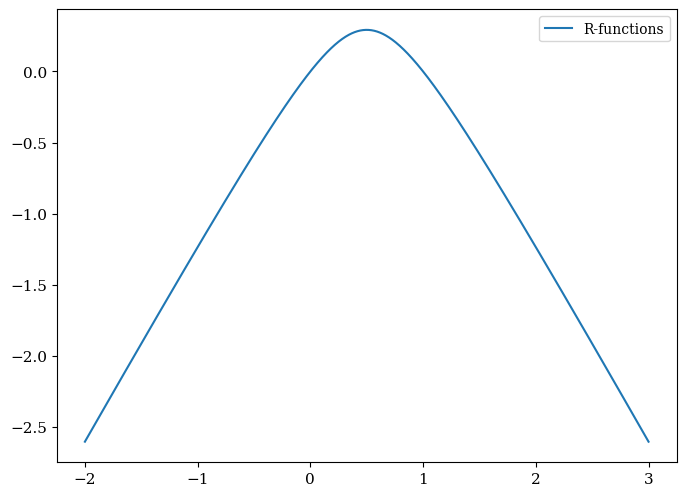

In [12]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x.cpu().detach().numpy(), yt.cpu().detach().numpy(), label='R-functions')
ax.legend()

In [13]:
# p-Poisson problem, p = 2
max_iteration = 15000
p = 2
model_p2 = trainPPoisson(max_iteration, fun=f, xbounds=xbounds, p=p, device=device)

In [14]:
yt_p2 = model_p2(xt)

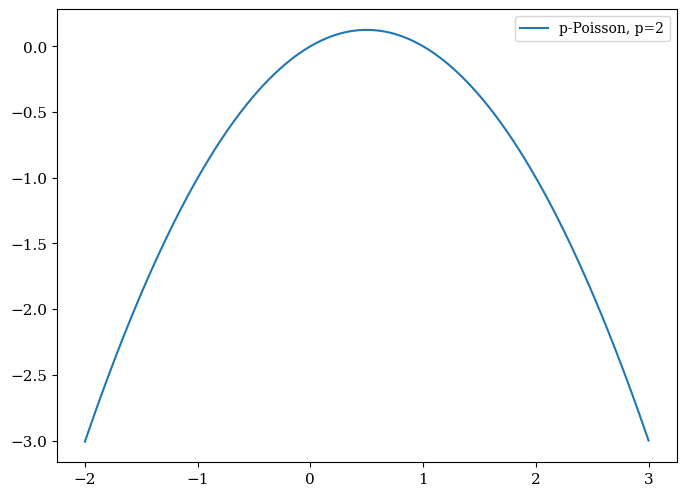

In [15]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x.cpu().detach().numpy(), yt_p2.cpu().detach().numpy(), label='p-Poisson, p=2')
ax.legend()

p=2
tensor(-1.0042, device='cuda:0', grad_fn=<MinBackward1>) tensor(-0.9971, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-1.0017, device='cuda:0', grad_fn=<MeanBackward0>)


(array([188., 209., 193.,  91.,  72.,  38.,  23.,  25.,  74.,  87.]),
 array([-1.0042377 , -1.0035287 , -1.0028199 , -1.002111  , -1.0014021 ,
        -1.0006932 , -0.9999843 , -0.99927545, -0.9985665 , -0.99785763,
        -0.99714875], dtype=float32),
 <a list of 10 Patch objects>)

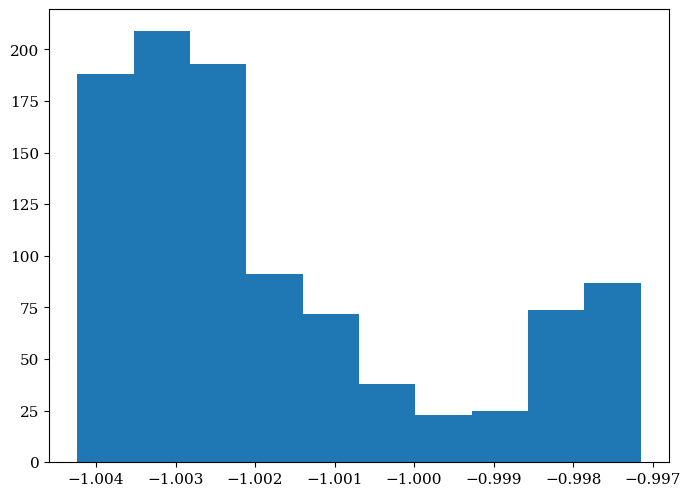

In [16]:
# When solving the p-Laplacian problem, check the distribution of the p-Laplacian
print('p='+str(p))
lap_p2 = pLaplacian(yt_p2, xt, p=p)
print(str(lap_p2.min()) + ' ' + str(lap_p2.max()) + ' ' + str(lap_p2.mean()))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.hist(lap_p2.cpu().detach().numpy())

In [17]:
# p-Poisson problem, p = 8
max_iteration = 15000
p = 8
model_p8 = trainPPoisson(max_iteration, fun=f, xbounds=xbounds, p=p, device=device)

In [18]:
yt_p8 = model_p8(xt)

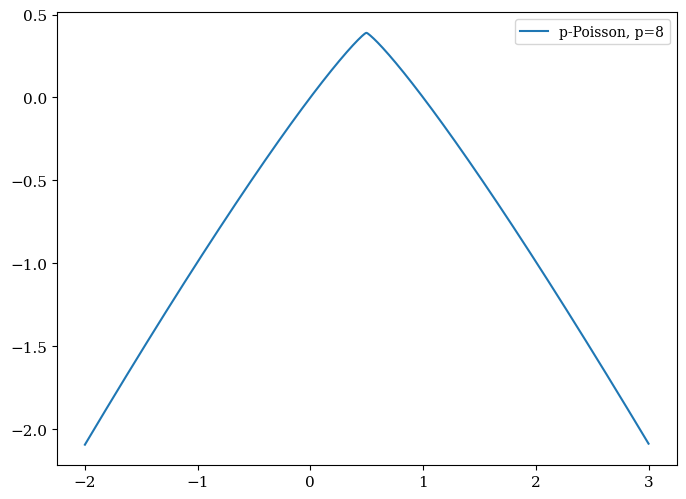

In [19]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x.cpu().detach().numpy(), yt_p8.cpu().detach().numpy(), label='p-Poisson, p=8')
ax.legend()

p=8
tensor(-1.1659, device='cuda:0', grad_fn=<MinBackward1>) tensor(-5.0926e-08, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.9875, device='cuda:0', grad_fn=<MeanBackward0>)


(array([145., 756.,  88.,   6.,   2.,   0.,   0.,   2.,   0.,   1.]),
 array([-1.1659110e+00, -1.0493199e+00, -9.3272877e-01, -8.1613767e-01,
        -6.9954658e-01, -5.8295548e-01, -4.6636441e-01, -3.4977332e-01,
        -2.3318224e-01, -1.1659114e-01, -5.0925820e-08], dtype=float32),
 <a list of 10 Patch objects>)

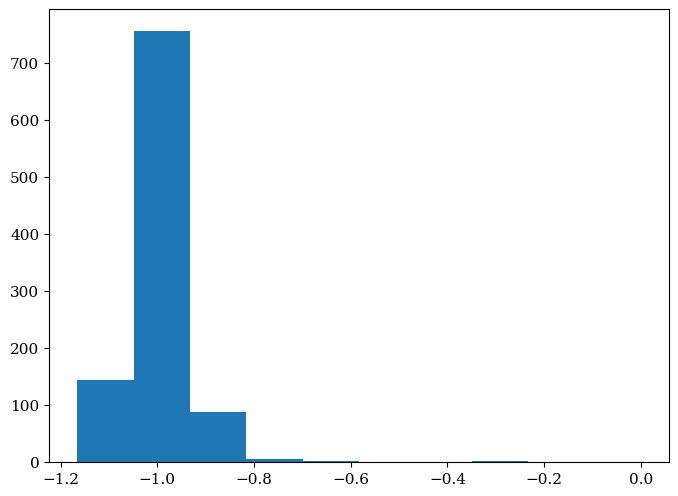

In [20]:
# When solving the p-Laplacian problem, check the distribution of the p-Laplacian
print('p='+str(p))
lap_8 = pLaplacian(yt_p8, xt, p=p)
print(str(lap_8.min()) + ' ' + str(lap_8.max()) + ' ' + str(lap_8.mean()))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.hist(lap_8.cpu().detach().numpy())

In [21]:
# Eikonal problem
max_iteration = 15000
model_eik = trainEikonal(max_iteration, fun=f, xbounds=xbounds, device=device)

In [22]:
yt_eik = model_eik(xt)

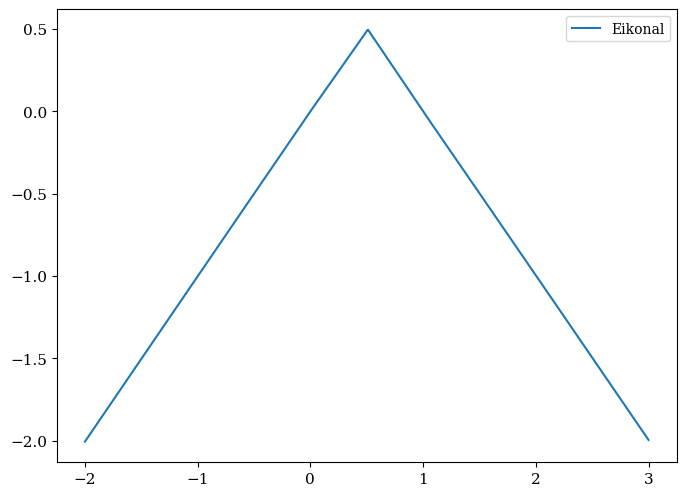

In [23]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x.cpu().detach().numpy(), yt_eik.cpu().detach().numpy(), label='Eikonal')
ax.legend()

tensor(0.9409, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.1337, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)


(array([  4.,  71., 257., 645.,  21.,   1.,   0.,   0.,   0.,   1.]),
 array([0.9409472 , 0.9602216 , 0.979496  , 0.99877036, 1.0180448 ,
        1.0373192 , 1.0565935 , 1.075868  , 1.0951424 , 1.1144168 ,
        1.1336912 ], dtype=float32),
 <a list of 10 Patch objects>)

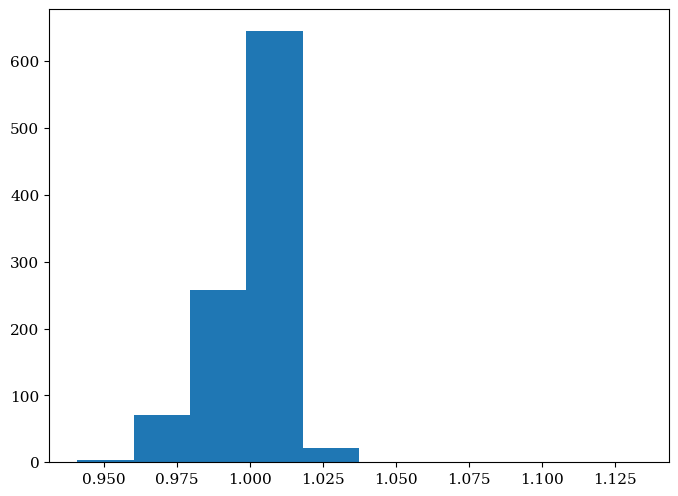

In [24]:
# When solving the Eikonal equation, check the gradient
g_yt_eik = grad(yt_eik, xt)
g_yt_eik_norm = g_yt_eik.norm(2, dim=1)
print(str(g_yt_eik_norm.min()) + ' ' + str(g_yt_eik_norm.max()) + ' ' + str(g_yt_eik_norm.mean()))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.hist(g_yt_eik_norm.cpu().detach().numpy())